# Week 4

Physical environmental variables regressed on seaice.   We start by loading in the different variables and inspecting the data.

In [1]:
import xarray as xr
import pandas as pd
import itertools
from tqdm import tqdm
from modules import *
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
# ds = xr.open_mfdataset('processed_data/ERA5-levels/*')

In [3]:
# for variable in ds:
#     if 'level' in ds[variable].dims:
#         for level in ds.level:
#             ds[variable+'_'+str(level.values)] = ds[variable].sel(level=level)
#         ds = ds.drop(variable)
# ds = ds.drop('level')

In [4]:
# seaice = w3.load_data(['seaice'],projection='SouthPolarStereo', temporal_resolution='annual',temporal_decomposition='anomalous',detrend='raw')

In [5]:
# ds = ds.interp(time=seaice.time)
# ds.to_netcdf('processed_data/environmental.nc')

In [6]:
ds = xr.open_dataset('processed_data/environmental.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 42, x: 316, y: 332)
Coordinates:
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2020-01-01
Data variables:
    si10     (time, y, x) float64 ...
    skt      (time, y, x) float64 ...
    sp       (time, y, x) float64 ...
    ssr      (time, y, x) float64 ...
    ssrd     (time, y, x) float64 ...
    sst      (time, y, x) float64 ...
    t2m      (time, y, x) float64 ...
    u10      (time, y, x) float64 ...
    v10      (time, y, x) float64 ...
    o3_200   (time, y, x) float64 ...
    o3_500   (time, y, x) float64 ...
    o3_700   (time, y, x) float64 ...
    t_200    (time, y, x) float64 ...
    t_500    (time, y, x) float64 ...
    t_700    (time, y, x) float64 ...
    u_200    (time, y, x) float64 ...
    u_500    (time, y, x) float64 ...
    u_700    (time, y, x) float64 ...
    v_200    (time, y, x) float64 ...
    v_500    (time, y, x) float64 ...
    v_700    (time, y, x) float64 ...
    z_200    (time, y, x) float64 ...
    z_500    (time, y, x) float64 ...
    z_700    (time, y, x) float64 ...

In [7]:
ds = xr.open_dataset('processed_data/environmental.nc')
v = [v for v in ds]
correlation_matrix = pd.DataFrame(index=v,columns=v, dtype=np.float64)
for v1,v2 in tqdm(list(itertools.product(v,v))):
    vec1 = ds[v1].mean(dim=('x','y'))
    vec2 = ds[v2].mean(dim=('x','y'))
#     fig = plt.figure()
#     ax = plt.gca()
#     ax.plot(vec1.time,vec1)
#     ax2 = ax.twinx()
#     ax2.plot([],[])
#     ax2.plot(vec1.time,vec2)
#     plt.title(f'{v1} and {v2}')
#     plt.show()
    correlation_matrix.loc[v1,v2]=xr.corr(vec1,vec2).values

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [00:36<00:00, 15.90it/s]


In [8]:
def significant_bold(val, sig_level=0.9):
    bold = 'bold' if val > sig_level else ''
    return 'font-weight: %s' % bold

In [9]:
# correlation_matrix.to_latex('H:\\Github/Environmental-Impact-on-Sea-Ice/correlations.tex')
correlation_matrix.style.applymap(significant_bold,sig_level=0.9)

,si10,skt,sp,ssr,ssrd,sst,t2m,u10,v10,o3_200,o3_500,o3_700,t_200,t_500,t_700,u_200,u_500,u_700,v_200,v_500,v_700,z_200,z_500,z_700
si10,1.000000,-0.610192,-0.722016,0.314642,0.415909,-0.547637,-0.505262,0.817590,-0.697487,-0.189754,-0.189760,-0.189752,-0.555901,-0.555902,-0.555897,0.821934,0.821923,0.821945,0.049614,0.049661,0.049572,-0.735375,-0.735381,-0.735373
skt,-0.610192,1.000000,0.571246,-0.400941,-0.574234,0.815824,0.982884,-0.669398,0.581224,0.432959,0.432958,0.432958,0.682250,0.682248,0.682250,-0.728014,-0.728009,-0.728023,0.016570,0.016544,0.016584,0.792509,0.792510,0.792506
sp,-0.722016,0.571246,1.000000,-0.283371,-0.388930,0.364748,0.515523,-0.804376,0.700641,0.030660,0.030668,0.030659,0.324288,0.324293,0.324285,-0.781099,-0.781100,-0.781097,-0.000113,-0.000121,-0.000116,0.888440,0.888438,0.888442
ssr,0.314642,-0.400941,-0.283371,1.000000,0.918426,-0.260655,-0.425500,0.223715,-0.091376,-0.115837,-0.115841,-0.115834,-0.532393,-0.532393,-0.532393,0.255390,0.255390,0.255386,0.081413,0.081415,0.081403,-0.494526,-0.494528,-0.494528
ssrd,0.415909,-0.574234,-0.388930,0.918426,1.000000,-0.458950,-0.587402,0.337046,-0.195593,-0.192362,-0.192365,-0.192360,-0.582717,-0.582716,-0.582719,0.385324,0.385324,0.385321,0.112243,0.112263,0.112222,-0.599729,-0.599730,-0.599732
sst,-0.547637,0.815824,0.364748,-0.260655,-0.458950,1.000000,0.774543,-0.493200,0.408931,0.535281,0.535279,0.535280,0.579149,0.579145,0.579149,-0.537969,-0.537963,-0.537979,0.011881,0.011827,0.011911,0.555911,0.555913,0.555908
t2m,-0.505262,0.982884,0.515523,-0.425500,-0.587402,0.774543,1.000000,-0.582770,0.464410,0.434296,0.434295,0.434296,0.674481,0.674479,0.674482,-0.630289,-0.630287,-0.630297,-0.035918,-0.035934,-0.035914,0.766760,0.766759,0.766758
u10,0.817590,-0.669398,-0.804376,0.223715,0.337046,-0.493200,-0.582770,1.000000,-0.863662,-0.193761,-0.193769,-0.193761,-0.425274,-0.425269,-0.425271,0.969511,0.969514,0.969510,0.080113,0.080149,0.080093,-0.769924,-0.769924,-0.769922
v10,-0.697487,0.581224,0.700641,-0.091376,-0.195593,0.408931,0.464410,-0.863662,1.000000,0.151044,0.151050,0.151045,0.353042,0.353043,0.353039,-0.916538,-0.916533,-0.916541,0.356272,0.356230,0.356294,0.655003,0.655005,0.655000
o3_200,-0.189754,0.432959,0.030660,-0.115837,-0.192362,0.535281,0.434296,-0.193761,0.151044,1.000000,1.000000,1.000000,0.546228,0.546229,0.546231,-0.221832,-0.221829,-0.221835,-0.058835,-0.058852,-0.058826,0.273245,0.273244,0.273240


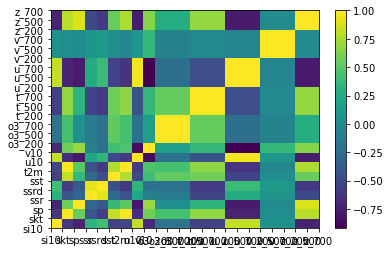

In [10]:
plt.pcolormesh(v,v,correlation_matrix.transpose())
plt.colorbar()
plt.show()

Looking at the above code, variables which have similar behaviors are either ones on different levels or t2m and skt. So we will compute regressions for each level seperately, ignoring skin temperature for now.

## Linear regression model

In [50]:
import xarray as xr
import pandas as pd
import itertools
from tqdm import tqdm
from modules import *
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# Normalize the variables this will be reversed later
ds = xr.open_dataset('processed_data/environmental.nc')

mean_vec = ds.mean()
std_vec = ds.std()

ds = (ds-mean_vec)/std_vec
ds

<xarray.Dataset>
Dimensions:  (time: 42, x: 316, y: 332)
Coordinates:
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2020-01-01
Data variables:
    si10     (time, y, x) float64 -3.691 -3.691 -3.691 ... 0.1654 0.1676 0.152
    skt      (time, y, x) float64 -22.2 -22.2 -22.2 -22.2 ... 1.296 1.313 1.325
    sp       (time, y, x) float64 -9.175 -9.175 -9.175 ... 0.6015 0.6026 0.604
    ssr      (time, y, x) float64 -2.7 -2.7 -2.7 -2.7 ... 1.287 1.288 1.289 1.29
    ssrd     (time, y, x) float64 -4.065 -4.065 -4.065 ... 0.2426 0.2438 0.2452
    sst      (time, y, x) float64 -43.38 -43.38 -43.38 ... 1.706 1.74 1.763
    t2m      (time, y, x) float64 -23.16 -23.16 -23.16 ... 1.296 1.305 1.312
    u10      (time, y, x) float64 -0.5684 -0.5684 -0.5684 ... 0.5889 0.5779
    v10      (time, y, x) float64 0.0803 0.0803 0.0803 ... -0.6477 -0.6324
    o3_200   (time, y, x) float64 -0.9573 -0.9573 0.4832 ... -0.7123 -0.7121
    o3_500   (time, y, x) float64 -0.9573 -0.9573 0.4853 ... -0.7122 -0.712
    o3_700   (time, y, x) float64 -0.9573 -0.9573 0.4878 ... -0.7122 -0.7117
    t_200    (time, y, x) float64 -15.23 -15.23 -1.738 ... 1.877 1.895 1.914
    t_500    (time, y, x) float64 -15.23 -15.23 -1.739 ... 1.883 1.901 1.92
    t_700    (time, y, x) float64 -15.23 -15.23 -1.739 ... 1.889 1.907 1.926
    u_200    (time, y, x) float64 -1.058 -1.058 0.1112 ... 0.5387 0.5117 0.4837
    u_500    (time, y, x) float64 -1.058 -1.058 0.1126 ... 0.5302 0.5024 0.4745
    u_700    (time, y, x) float64 -1.058 -1.058 0.1149 ... 0.5211 0.4931 0.4653
    v_200    (time, y, x) float64 -0.0006037 -0.0006037 1.892 ... -1.086 -1.026
    v_500    (time, y, x) float64 -0.0005984 -0.0005984 1.841 ... -1.064 -1.008
    v_700    (time, y, x) float64 -0.0006055 -0.0006055 1.789 ... -1.044 -0.9923
    z_200    (time, y, x) float64 -1.774 -1.774 1.502 ... -0.9485 -0.9469
    z_500    (time, y, x) float64 -1.774 -1.774 1.501 ... -0.9479 -0.9463
    z_700    (time, y, x) float64 -1.774 -1.774 1.501 ... -0.949 -0.9474 -0.9458

In [52]:
seaice = w3.load_data(['seaice'],projection='SouthPolarStereo', temporal_resolution='annual',temporal_decomposition='anomalous',detrend='raw')
ds['seaice'] = seaice['seaice']

v = [v for v in ds]
x_surface = ['si10','sp','ssr','sst','t2m','u10','v10']
x_200 = [vi for vi in v if '_200' in vi]
x_500 = [vi for vi in v if '_500' in vi]
x_700 = [vi for vi in v if '_700' in vi]

for x in [x_surface, x_200, x_500, x_700]:
    print('Regressing variables: ', x)
    regression_results = w3.multiple_fast_regression(ds, 'seaice', x)
    v2 = [vi for vi in regression_results if vi not in v]
    for vi in v2:
        ds[vi] = regression_results[vi]
ds

Regressing variables:  ['si10', 'sp', 'ssr', 'sst', 't2m', 'u10', 'v10']
Finding coefficients


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:01<00:00, 62170.60it/s]


Predicting SIC
Regressing variables:  ['o3_200', 't_200', 'u_200', 'v_200', 'z_200']
Finding coefficients


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:05<00:00, 19599.90it/s]


Predicting SIC
Regressing variables:  ['o3_500', 't_500', 'u_500', 'v_500', 'z_500']
Finding coefficients


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:05<00:00, 19665.85it/s]


Predicting SIC
Regressing variables:  ['o3_700', 't_700', 'u_700', 'v_700', 'z_700']
Finding coefficients


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:05<00:00, 19388.36it/s]


Predicting SIC


<xarray.Dataset>
Dimensions:            (time: 42, x: 316, y: 332)
Coordinates:
  * time               (time) datetime64[ns] 1979-01-01 ... 2020-01-01
  * y                  (y) int32 4350000 4325000 4300000 ... -3900000 -3925000
  * x                  (x) int32 -3950000 -3925000 -3900000 ... 3900000 3925000
Data variables:
    si10               (time, y, x) float64 -3.691 -3.691 ... 0.1676 0.152
    skt                (time, y, x) float64 -22.2 -22.2 -22.2 ... 1.313 1.325
    sp                 (time, y, x) float64 -9.175 -9.175 ... 0.6026 0.604
    ssr                (time, y, x) float64 -2.7 -2.7 -2.7 ... 1.288 1.289 1.29
    ssrd               (time, y, x) float64 -4.065 -4.065 ... 0.2438 0.2452
    sst                (time, y, x) float64 -43.38 -43.38 -43.38 ... 1.74 1.763
    t2m                (time, y, x) float64 -23.16 -23.16 -23.16 ... 1.305 1.312
    u10                (time, y, x) float64 -0.5684 -0.5684 ... 0.5889 0.5779
    v10                (time, y, x) float64 0.0803 0.0803 ... -0.6477 -0.6324
    o3_200             (time, y, x) float64 -0.9573 -0.9573 ... -0.7123 -0.7121
    o3_500             (time, y, x) float64 -0.9573 -0.9573 ... -0.7122 -0.712
    o3_700             (time, y, x) float64 -0.9573 -0.9573 ... -0.7122 -0.7117
    t_200              (time, y, x) float64 -15.23 -15.23 -1.738 ... 1.895 1.914
    t_500              (time, y, x) float64 -15.23 -15.23 -1.739 ... 1.901 1.92
    t_700              (time, y, x) float64 -15.23 -15.23 -1.739 ... 1.907 1.926
    u_200              (time, y, x) float64 -1.058 -1.058 ... 0.5117 0.4837
    u_500              (time, y, x) float64 -1.058 -1.058 ... 0.5024 0.4745
    u_700              (time, y, x) float64 -1.058 -1.058 ... 0.4931 0.4653
    v_200              (time, y, x) float64 -0.0006037 -0.0006037 ... -1.026
    v_500              (time, y, x) float64 -0.0005984 -0.0005984 ... -1.008
    v_700              (time, y, x) float64 -0.0006055 -0.0006055 ... -0.9923
    z_200              (time, y, x) float64 -1.774 -1.774 ... -0.9485 -0.9469
    z_500              (time, y, x) float64 -1.774 -1.774 ... -0.9479 -0.9463
    z_700              (time, y, x) float64 -1.774 -1.774 ... -0.9474 -0.9458
    seaice             (x, y, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 nan nan
    prediction_name    (x, y, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 nan nan
    regr_coef_si10     (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_sp       (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_ssr      (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_sst      (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_t2m      (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_u10      (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_v10      (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_error    (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prediction_si10    (x, y, time) float64 nan nan nan nan ... nan nan nan nan
    prediction_sp      (x, y, time) float64 nan nan nan nan ... nan nan nan nan
    prediction_ssr     (x, y, time) float64 nan nan nan nan ... nan nan nan nan
    prediction_sst     (x, y, time) float64 nan nan nan nan ... nan nan nan nan
    prediction_t2m     (x, y, time) float64 nan nan nan nan ... nan nan nan nan
    prediction_u10     (x, y, time) float64 nan nan nan nan ... nan nan nan nan
    prediction_v10     (x, y, time) float64 nan nan nan nan ... nan nan nan nan
    regr_coef_o3_200   (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_t_200    (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_u_200    (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_v_200    (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_z_200    (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prediction_o3_200  (x, y, time) float64 0.0 0.0 0.0 0.0 ... 